#Getting started with Theano

This lab was created by Jon Barker

The following timer counts down to a five minute warning before the lab instance shuts down.  You should get a pop up at the five minute warning reminding you to save your work!  If you are about to run out of time, please see the [Post-Lab](#Post-Lab-Summary) section for saving this lab to view offline later.

<iframe id="timer" src="timer/timer.html" width="100%" height="120px"></iframe>

---
Before we begin, let's verify [WebSockets](http://en.wikipedia.org/wiki/WebSocket) are working on your system.  To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Ctrl-Enter, or pressing the play button in the toolbar above.  If all goes well, you should see some output returned below the grey cell.  If not, please consult the [Self-paced Lab Troubleshooting FAQ](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) to debug the issue.

In [1]:
print "The answer should be three: " + str(1+2)

The answer should be three: 3


Let's execute the cell below to display information about the GPUs running on the server.

In [2]:
!nvidia-smi

Fri Jan 15 19:41:27 2016       
+------------------------------------------------------+                       
| NVIDIA-SMI 346.46     Driver Version: 346.46         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           On   | 0000:00:03.0     Off |                  N/A |
| N/A   29C    P8    17W / 125W |     10MiB /  4095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Introduction

Theano is a Python library that allows you to write symbolic mathematical expressions and compile them onto different computational architectures (in particular, CPU and GPU). It was developed by machine learning researchers at the University of Montreal. Its use is not limited to machine learning applications, but it was designed with machine learning in mind. It's especially good for machine learning techniques which are CPU-intensive and benefit from parallelization (e.g. large neural networks).

In this class we will demonstrate Theano's explicit representation of symbolic maths and it's ability to compile that representation into efficient code to be applied to numerical data. We are going to work through one of the most fundamental applications of articial neural networks - the multi-layer perceptron.  This example will allow us to see a complete neural network being defined and trained from scratch, but the process we will follow in Theano is essentially the same for some of the much more complicated networks, such as Convolutional Neural Networks (CNNs), that we have seen in our previous classes.  We will finish the class by getting you started in extending the multi-layer perceptron example into a CNN.

## Key Theano concepts

We will begin by introducing some important general concepts that form the basis for all computation in Theano.

First we must import Theano into Python.  Notice that Theano is using the GPU - there is no more GPU configuration required when using Theano, the GPU will be leveraged for all applicable computations.  This was achieved by creating a file `.theanorc` file in our home directory that specified the flag `device=gpu`.  This configuration file is referenced by Theano when it is imported into Python.

Execute the cell below to import Theano into Python.

You will know the lab is processing when you see a solid circle in the top-right of the window that looks like this: ![](jupyter_executing.png)
Otherwise, when it is idle, you will see the following: ![](jupyter_idle.png)
If you ever feel like a cell has run for to long, you can stop it with the stop button in the toolbar.
For troubleshooting, please see [Self-paced Lab Troubleshooting FAQ](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) to debug the issue.


In [3]:
import numpy as np
import theano
# By convention, the tensor submodule is loaded as T
import theano.tensor as T

Using gpu device 0: GRID K520 (CNMeM is disabled)


### Symbolic variables

In Theano algorithms are defined symbolically.  This means that variables don't have to have explicit values.  The `theano.tensor` sub-module has various symbolic variable types.  Below is an example of a simple symbolic calculation using scalar variables. 

In [4]:
# Define a scalar variable
a = T.scalar('a')

# Define another variable as a squared
b = a**2

# b will also be a theano variable
print type(b)

# We can inspect how b is defined using theano's pretty print function
print theano.pp(b)

<class 'theano.tensor.var.TensorVariable'>
(a ** TensorConstant{2})


### Functions

To compute things in Theano using actual numerical values you define symbolic functions.

In [5]:
# We can't compute anything with a, b and c yet.
# We need to define a theano function first.
# The first argument of theano.function defines the inputs
f = theano.function([a],b)
print f(2)

4.0


In [6]:
# In some cases you can use a symbolic variable's eval method.
# This can be more concise and convenient that defining a function.
# If it has inputs, the eval method takes a Python dictionary where
# the keys are theano variables and the values are values for those
# variables.
print b.eval({a: 2})

4.0


### theano.tensor

Theano has variable types for vectors, matrices and tensors.  The `theano.tensor` sub-module has various functions for performing operations on these variables.

In [7]:
# Define symbolic matrix and vector variables
A = T.matrix('A')
x = T.vector('x')

# Define a symbolic function using these variables
y = T.dot(A, x)

# Define a theano function to compute y
linear_func = theano.function([A, x], y)

# Supply numeric values for A and x
print linear_func(np.array([[1,2,3],[4,5,6]], dtype=theano.config.floatX),
                  np.array([1,2,3], dtype=theano.config.floatX))

[ 14.  32.]


`theano.config.floatX` is a configuration variable that Theano also obtains from the `.theanorc` file.  Here it is used to specify the numerical type of the variables A and x.  If you are using GPU acceleration then `floatX` should be `float32`.

### Shared variables

Shared variables are Theano variables that do have an explcit value that can be get/set and is shared across all functions which use the variable.

In [8]:
shared_var = theano.shared(np.array([[1,2],[3,4]], dtype=theano.config.floatX))
print shared_var.type()
print shared_var.get_value()

<CudaNdarrayType(float32, matrix)>
[[ 1.  2.]
 [ 3.  4.]]


In [9]:
shared_var.set_value(np.array([[3, 4], [2, 1]], dtype=theano.config.floatX))
print shared_var.get_value()

[[ 3.  4.]
 [ 2.  1.]]


In [10]:
shared_squared = shared_var**2
# The first argument of theano.function (inputs) tells Theano what the arguments to the compiled function should be.
# Note that because shared_var is shared, it already has a value, so it doesn't need to be an input to the function.
# Therefore, Theano implicitly considers shared_var an input to a function using shared_squared and so we don't need
# to include it in the inputs argument of theano.function.
function_1 = theano.function([], shared_squared)
print function_1()

[[  9.  16.]
 [  4.   1.]]


### updates

The value of a shared variable can be updated in a function by using the `updates` argument of `theano.function`.

In [15]:
# We can also update the state of a shared var in a function
subtract = T.matrix('subtract')
# updates takes a dict where keys are shared variables and values are the new value the shared variable should take
# Here, updates will set shared_var = shared_var - subtract
function_2 = theano.function([subtract], shared_var, updates={shared_var: shared_var - subtract})
print "shared_var before subtracting [[1, 1], [1, 1]] using function_2:"
print shared_var.get_value()
# Subtract [[1, 1], [1, 1]] from shared_var
function_2(np.array([[1, 1], [1, 1]], dtype=theano.config.floatX))
print "shared_var after calling function_2:"
print shared_var.get_value()
# Note that this also changes the output of function_1, because shared_var is shared!
print "New output of function_1() (shared_var**2):"
print function_1()

shared_var before subtracting [[1, 1], [1, 1]] using function_2:
[[ 2.  3.]
 [ 1.  0.]]
shared_var after calling function_2:
[[ 1.  2.]
 [ 0. -1.]]
New output of function_1() (shared_var**2):
[[ 1.  4.]
 [ 0.  1.]]


## Example 1: Logistic regression

Now that we have seen the basic building blocks used in Theano we going to see a more practical application.  We're going to generate some toy data, simply two classes of points embedded in 2D space and seperated by the line $y=x$.  

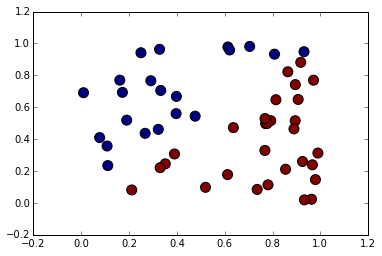

In [16]:
# Import some necessary Python visualization modules
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

# Generate 50 random 2-D points
x = np.random.random((50,2)).astype('float32')

# If point is above y=x then class is 1,
# otherwise class is 0
y = np.zeros((50,)).astype('int32')
y[x[:,0]>x[:,1]] = 1

# Plot the points 
plt.scatter(x[:,0], x[:,1], c=y, s=100)
plt.show()

Logistic regression is a probabilistic linear classifier.  That means it uses a linear model to predict the probability of the class that a data sample belongs to, where a data sample is a real-valued input vector.  Logistic regression achieves this by projecting these input vectors onto a set of hyperplanes, each one representing a class, and the distance of the data sample from the hyperplane boundary represents the probability that it is a member of that class.

Logistic regression is parameterized by a weight matrix $W$ and a bias vector $b$.  The probability that an input vector $x$ belongs to class $i$ can be written as: 

$$\Pr(Y=i \mid x,W,b)=softmax_i(Wx+b)$$

The linear function $Wx+b$ is equivalent to an artificial neural network layer where all input neurons are fully-connected to all output neurons.  The number of input neurons is the same as the number of dimensions in the input vector.  The dimensions of $W$ determine how many neurons are in the outut layer and this is equal to the number of classes.  The $softmax$ function simply "squashes" an arbitrary real-valued vector into a vector of the same dimensions but with values in the range (0,1) - in this example, softmax is applied to the output of $Wx+b$ so that we get probabilities of class membership.

Using Theano to express the mathematics, we define a logistic regression model as a Python class with a method that initializes the parameters as random real-valued numbers in [0,1] and feeds-forward an input vector.  We also define a method that will allow us to use the model in it's current state to classify new data samples.

In [17]:
class LogisticRegression(object):
    
    def __init__(self, input, n_in, n_out):

        # Initialize pseudo-random number generator
        rng = np.random.RandomState(1234)
        
        # Randomly generate weight matrix W
        W_values = np.asarray(
            rng.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
            ),
            dtype=theano.config.floatX
        )

        self.W = theano.shared(value=W_values, name='W', borrow=True)        

        # Randomly initialize bias vector b
        b_values = np.zeros((n_out,), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, name='b', borrow=True)

        # Define feed-forward function
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)
        
        # Specify parameters of layer
        self.params = [self.W, self.b]
        
    def predict(self, input):
        
        # Function to apply layer feedforward to new input data
        return T.nnet.softmax(T.dot(input, self.W) + self.b)

Notice that we define the two parameters of the logistic regression as Theano shared variables.  This declares them both as being symbolic Theano variables that mantain a persistent state throughout training the model.  Shared variables must have an explicit value set - they are not purely symbolic.

We can test our new class by passing in a random input vector.

In [18]:
# Define theano shared variables for the input data and labels
shared_x = theano.shared(np.asarray(x, dtype=theano.config.floatX), borrow=True)
shared_y = theano.shared(np.asarray(y, dtype=theano.config.floatX), borrow=True)
shared_y = T.cast(shared_y, 'int32')

# Initialize a logistic regressor with 2-dimensional inputs
# and 2 classes for output with the first row of x as input
lr = LogisticRegression(shared_x[0,:], 2, 2)
# Feed the first data sample from x through the regressor and print output
print lr.p_y_given_x.eval()

[[ 0.20062771  0.79937232]]


Because the feed-forward step of the logistic regression is just multiplication by a 2-dimensional matrix, we can actually pass into our class a whole matrix of input vectors where each row represents an individual data sample.  This is a good example of why GPU acceleration can be of great benefit in neural network training - these types of matrix multiplication commonly occur and can be parallelized.

In [19]:
# Initialize a logistic regressor with 2-dimensional inputs
# and 2 classes for output but now with all of x as input
lr = LogisticRegression(shared_x, 2, 2)
# Print the first 10 data samples from x through the regressor and print output
print lr.p_y_given_x.eval()[:10]

[[ 0.20062771  0.79937232]
 [ 0.22745155  0.77254838]
 [ 0.33795539  0.66204464]
 [ 0.42156744  0.57843256]
 [ 0.27868924  0.72131073]
 [ 0.26211172  0.73788828]
 [ 0.16638026  0.83361977]
 [ 0.29989687  0.70010316]
 [ 0.25336298  0.74663705]
 [ 0.22507016  0.77492988]]


So far our model is not very useful as all of the parameters have random values. In order to train the parameters of the network we must define a loss function.  A loss function measures how close the models predicted classification of a training data sample is to the actual known classification.  The training process will attempt to find values of $W$ and $b$ that will minimize this loss value across all of our training data samples.  We will use the common negative log-likelihood as the loss.  This is equivalent to maximizing the likelihood of the training set $D$ under the model parameterized by $W$ and $b$.  The loss is defined as:

$$L=-\sum_{i=0}^{|D|}log(P(Y=y^{(i)}|x^{(i)},W,B))$$

In Theano, we define the negative log loss function in the following way by creating another method operating on our logistic regression class.

In [20]:
def negative_log_likelihood(self, y):
    # y corresponds to a vector that gives for each data sample
    # the correct label
    return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

LogisticRegression.negative_log_likelihood = negative_log_likelihood

To train the model we will use an algorithm called stochastic gradient descent (SGD) with mini-batches (sometimes also called minibatch gradient descent (MGD)).  We will not expose the complete details of SGD in this introductory class, but the essential algorithm proceeds as follows.  First, we feed-forward a mini-batch of data samples through the model to get probabilistic class predictions.  Second, we compute the loss by comparing the predictions to the true class labels we have as part of our dataset.  Third, we update the model parameters in such a way that next time we feed-forward the same mini-batch through the model the loss will be lower. 

In order to update the parameters we must compute whether to make each one bigger or smaller to reduce the loss.  We work this out by computing what are called the *gradients* of the loss function with respect to the parameters.  In mathematical terms these are the partial derivatives of the loss function with respect to each of the parameters.  Intuitively, these tell you which direction and with what magnitude you must modify each of the parameters to reduce the loss.

Theano makes computing gradients very simple and this is a huge benefit.  Due to the symbolic definition of the loss function in terms of the parameters, we can simply call the Theano *grad* function to work out the gradients - no calculus required!

When you execute the cell below you will define a Theano function called `train`.  Defining this function causes Theano to compile our symbolic definition of the SGD algorithm into efficient GPU-enabled code that will operate on our numerical input data.  Notice that at no point in defining this function does an explicit numerical value need to be assigned to any of our variables - it is more like writing math than code!

In [21]:
# Initialize logistic regression model
lr = LogisticRegression(shared_x, 2, 2)

learning_rate = 0.1

# Allocate symbolic variables for the input data
X = T.matrix('X')
Y = T.ivector('Y')

# Begin training function definition based on symbolic mathematical operations
# Specify loss function
cost = lr.negative_log_likelihood(Y)

# Specify parameters to be updated by SGD algorithm
params = lr.params

# Compute gradients of parameters with respect to loss
grads = T.grad(cost, params)

# Compute parameter updates using SGD with momentum
# We use the values 0.1 for learning rate and 0.9 for momentum
updates = []  
for p, g in zip(params, grads):
    mparam_i = theano.shared(np.zeros(p.get_value().shape, dtype=theano.config.floatX))
    v = 0.9 * mparam_i - learning_rate * g
    updates.append((mparam_i, v))
    updates.append((p, p + v))

# Define theano function to be compiled to perform training update based on numerical data
train = theano.function(
    inputs=[],
    outputs=cost,
    updates=updates,
    givens={
        X: shared_x[:],
        Y: shared_y[:]
    }
)

When you execute the cell below you will see our logistic regression model train on the randomly generated data. After every 10 training iterations you will see the decision boundary between the two classes updated.

Iteration 290 of 300
Cost: 0.115982294083


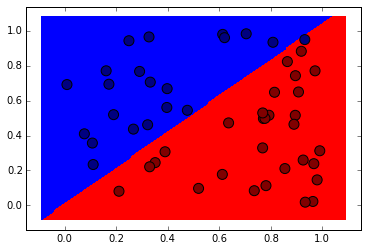

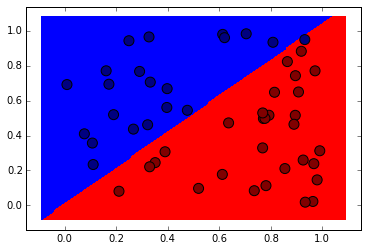

In [22]:
# Initialize decision surface for display
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                     np.arange(y_min, y_max, .01))

# Perform 300 training iterations
for i in range(0,300):
    
    # Perform SGD update
    cost = train()
    
    # Compute decision surface
    Z = np.argmax(lr.predict(np.c_[xx.ravel(), yy.ravel()].astype('float32')).eval(),1)
    Z = Z.reshape(xx.shape)
    
    # Every 10 iterations, visualize decision surface
    if i%10==0:
        display.clear_output(wait=True)
        print 'Iteration ' + str(i) + ' of 300'
        print 'Cost: ' + str(cost)
        plt.contourf(xx, yy, Z, levels=[-1,0,1], colors=['b','r'])
        plt.scatter(x[:,0], x[:,1], c=y, s=100)
        display.display(plt.gcf())

We see that we are able to quickly learn a decision boundary between the two classes of points which allows the logistic regression function to accurately classify them.  Now let's see what happens if we have a more complicated distribution of points in our two classes.

####Q #1: 

What is the effect of reducing the learning rate value in the train function?  Try setting the *learning_rate* variable to 0.001 and then executing the last two cells again.

**A**: See [Answer #1 below](#Answer-#1)

Next we will generate a new set of points where one class lies within the circle defined by $x^2+y^2=0.5$ and the other class lies outside it.

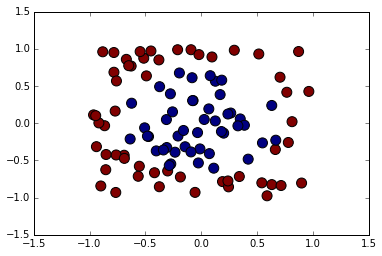

In [23]:
# Generate 100 random points
# Class one is points inside x^2 + y^2 = 0.5
# Class two is points outside x^2 + y^2 = 0.5
x = 2 * np.random.random((100,2)).astype('float32') - 1
y = np.zeros((100,)).astype('int32')
y[np.sum(np.square(x),1) > 0.5] = 1

# Plot the points 
plt.scatter(x[:,0], x[:,1], c=y, s=100)
plt.show()

When you execute the cell below you will define a Theano function called `train`.  This function causes Theano to compile our symbolic definition of the SGD algorithm into efficient GPU-enabled code that will operate on our numerical input data.

In [24]:
# Define theano shared variables for the second set of input data and labels
shared_x = theano.shared(np.asarray(x, dtype=theano.config.floatX), borrow=True)
shared_y = theano.shared(np.asarray(y, dtype=theano.config.floatX), borrow=True)
shared_y = T.cast(shared_y, 'int32')

# Initialize logistic regression model
lr = LogisticRegression(shared_x, 2, 2)

# Allocate symbolic variables for the input data
X = T.matrix('X')
Y = T.ivector('Y')

# Specify parameters to be updated by SGD algorithm
params = lr.params

# Begin training function definition based on symbolic mathematical operations
# Specify loss function
cost = lr.negative_log_likelihood(Y)

# Compute gradients of parameters with respect to loss
grads = T.grad(cost, params)

# Compute parameter updates using SGD with momentum
# We use the values 0.1 for learning rate and 0.9 for momentum
updates = []    
for p, g in zip(params, grads):
    mparam_i = theano.shared(np.zeros(p.get_value().shape, dtype=theano.config.floatX))
    v = 0.9 * mparam_i - 0.1 * g
    updates.append((mparam_i, v))
    updates.append((p, p + v))

# Define theano function to be compiled to perform training update based on numerical data
train = theano.function(
    inputs=[],
    outputs=cost,
    updates=updates,
    givens={
        X: shared_x[:],
        Y: shared_y[:]
    }
)

When you execute the cell below you will see our logistic regression model train on the second, more complicated, set of randomly generated data.  After every 10 training iterations you will see the decision boundary between the two classes updated.

Iteration 290 of 300
Cost: 0.678158700466


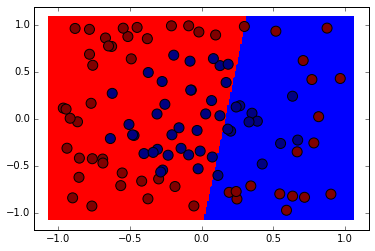

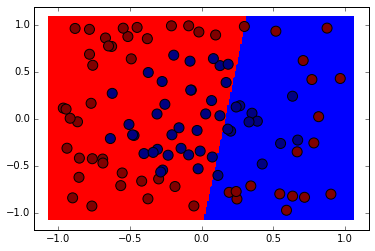

In [25]:
# Initialize decision surface for display
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                     np.arange(y_min, y_max, .01))

# Perform 300 training iterations
for i in range(0,300):
    
    # Perform SGD update
    cost = train()
    
    # Compute decision surface
    Z = np.argmax(lr.predict(np.c_[xx.ravel(), yy.ravel()].astype('float32')).eval(),1)
    Z = Z.reshape(xx.shape)
    
    # Every 10 iterations, visualize decision surface
    if i%10==0:
        display.clear_output(wait=True)
        print 'Iteration ' + str(i) + ' of 300'
        print 'Cost: ' + str(cost)
        plt.contourf(xx, yy, Z, levels=[-1,0,1], colors=['b','r'])
        plt.scatter(x[:,0], x[:,1], c=y, s=100)
        display.display(plt.gcf())

This time we see that our logistic regression model is unable to find a decision boundary that can accurately seperate the two classes.  Due to the random parameter initialization and random data generation the exact outcome will be different each time, but often you will find that the model converges on a decision boundary where all data points get classified in the same class.  

The reason this logistic regression model cannot accurately seperate the two classes is because it is limited to only finding a linear function, i.e. a straight line, that can seperate them.  In order to better classify this data we must increase the complexity of function that our model can learn - Theano enables us to easily do this as a logical extension to our current model.

## Example 2: Multilayer perceptron

As mentioned earlier, the logistic regression model we defined is equivalent to an artificial neural network with a single layer of input neurons fully connected to a single layer of output neurons.  Another name for a network of this type is a *(single-layer) perceptron*.  We can extend this simple model to give it the ability to learn more complex non-linear decision boundaries by adding another layer to the neural network between the inputs and the outputs.  We call this additional layer a *hidden* layer.  When we do so we create what is called a *multilayer perceptron*.  The mathematical form of this additional layer is exactly the same as before.  The only difference is that we now use a hyperbolic tangent (tanh) activation function in the first hidden layer and keep the softmax activation in the output layer.

In [26]:
class hidden(object):
    
    def __init__(self, input, n_in, n_out):

        # Initialize pseudo-random number generator
        rng = np.random.RandomState(1234)
        
        # Randomly generate weight matrix W
        W_values = np.asarray(
            rng.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
            ),
            dtype=theano.config.floatX
        )

        self.W = theano.shared(value=W_values, name='W', borrow=True)        
        
        # Randomly initialize bias vector b
        b_values = np.zeros((n_out,), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, name='b', borrow=True)
        
        # Define feed-forward function
        self.hidden = T.tanh(T.dot(input, self.W) + self.b)
        
        # Specify parameters of layer
        self.params = [self.W, self.b]
        
    def feedforward(self, input):
        
        # Function to apply layer feedforward to new input data
        return T.tanh(T.dot(input, self.W) + self.b)

When you execute the cell below you will define a Theano function called `train`.  This function causes Theano to compile our symbolic definition of the SGD algorithm into efficient GPU-enabled code that will operate on our numerical input data.

In [27]:
# Initialize multi-layer perceptron
# i.e., initialize a hidden layer followed by a logistic regression layer
layer0 = hidden(shared_x, 2, 10)
layer1 = LogisticRegression(layer0.hidden, 10, 2)

# Allocate symbolic variables for the input data
X = T.matrix('X')
Y = T.ivector('Y')

# Begin training function definition based on symbolic mathematical operations
# Specify loss function
cost = layer1.negative_log_likelihood(Y)

# Specify parameters to be updated by SGD algorithm
params = layer0.params + layer1.params

# Compute gradients of parameters with respect to loss
grads = T.grad(cost, params)

# Compute parameter updates using SGD with momentum
# We use the values 0.1 for learning rate and 0.9 for momentum
updates = []    
for p, g in zip(params, grads):
    mparam_i = theano.shared(np.zeros(p.get_value().shape, dtype=theano.config.floatX))
    v = 0.9 * mparam_i - 0.1 * g
    updates.append((mparam_i, v))
    updates.append((p, p + v))

# Define theano function to be compiled to perform training update based on numerical data
train = theano.function(
    inputs=[],
    outputs=cost,
    updates=updates,
    givens={
        X: shared_x[:],
        Y: shared_y[:]
    }
)

When you execute the cell below you will see our multi-layer perceptron model train on the second, more complicated, set of randomly generated data.  After every 10 training iterations you will see the decision boundary between the two classes updated.

Iteration 290 of 300
Cost: 0.114320635796


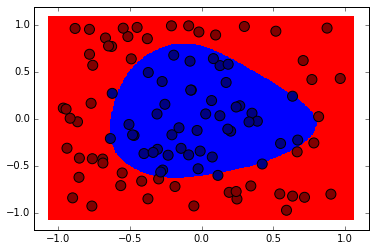

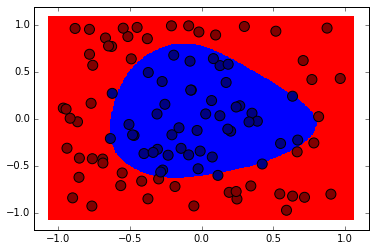

In [28]:
# Initialize decision surface for display
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                     np.arange(y_min, y_max, .01))

# Perform 300 training iterations
for i in range(0,300):
    
    # Perform SGD update
    cost = train()
    
    # Compute decision surface
    Z = np.argmax(layer1.predict(layer0.feedforward((np.c_[xx.ravel(), yy.ravel()].astype('float32')))).eval(),1)
    Z = Z.reshape(xx.shape)
    
    # Every 10 iterations, visualize decision surface
    if i%10==0:
        display.clear_output(wait=True)
        print 'Iteration ' + str(i) + ' of 300'
        print 'Cost: ' + str(cost)
        plt.contourf(xx, yy, Z, levels=[-1,0,1], colors=['b','r'])
        plt.scatter(x[:,0], x[:,1], c=y, s=100)
        display.display(plt.gcf())

We now see that the addition of a second layer in our neural network allows us to learn the more complicated decision boundary required to seperate the two classes.

## Recap

We have seen so far that in Theano we can define an artificial neural network layer-by-layer as a sequence of Python classes.  We have also seen that we can define the loss function as a method on the final layer's class. We can then define a Theano function to train this network and we can make use of the Theano grad function so that we don't have to analytically work out the gradients of our loss function.

Furthermore, we have seen that Theano's close syntactical resemblance to NumPy makes it very easy to integrate Theano functions into a Python data processing pipeline.

This basic recipe for defining and training artificial neural networks in Theano can be extended to develop the most complicated, cutting edge networks being used in Deep Learning research today.  To see some examples of more complicated network types being defined and trained in Theano I recommend you look at the [Deep Learning Tutorials](http://deeplearning.net/tutorial/) made available by the Theano developers.

## Example 3: Convolutional layers

The `theano.tensor` sub-module offers many functions for operating on symbolic variables.  One such function is called `theano.tensor.signal.conv2d` and it is used for implementing the convolutional layers that are critical in computer vision applications.

`theano.tensor.signal.conv2d` takes two symbolic inputs:

- a 4D tensor corresponding to a mini-batch of input images.  The shape of the tensor is: [mini-batch size, number of input feature maps, image height, image width].
- a 4D tensor corresponding to the weight matrix $W$.  The shape of this tensor is: [number of feature maps at layer m, number of feature maps at layer m-1, filter height, filter width].

Below is Theano code for implementing a convolutional layer.  The layer has 3 input feature maps, i.e. an RGB image, of size 512x512.  We use two convolutional filters with 9x9 receptive fields.

In [29]:
from theano.tensor.nnet import conv

# Initialize 4D tensor for input
input = T.tensor4(name='input')

# Specify height and width of convolutional filters
filter_shape = (9, 9)

# Initialize shared variable for weights
w_shp = (2,3,filter_shape[0],filter_shape[1])
w_bound = np.sqrt(3 * np.prod(filter_shape))
W = theano.shared(np.asarray(
        np.random.uniform(
            low=-1.0 / w_bound,
            high=1.0 / w_bound,
            size=w_shp),
        dtype=input.dtype), name='W')

# build symbolic expression that computes the convolution
# of the input with the filters in W
conv_out = conv.conv2d(input, W)

# build symbolic expression to apply sigmoid activation function
# NOTE: for simplicity we are ommiting the bias vector that
# would also normally be added
output = T.nnet.sigmoid(conv_out)

# create theano function to compute filtered images
f = theano.function([input], output)

Let's see what happens when we apply our layer to Lena...

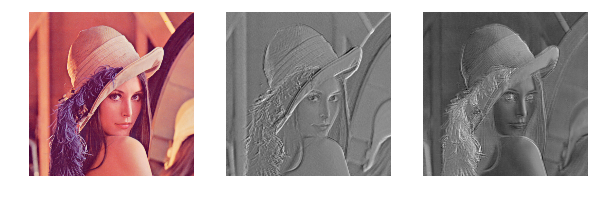

In [30]:
# import the lena image from skimage
import skimage.data
lena = skimage.data.lena()

# put the image in 4D tensor of shape (1,3, height, width)
img = np.asarray(lena, dtype='float32') / 256
img_ = img.transpose(2, 0, 1).reshape(1, 3, 512, 512)

# apply convolutional layer
filtered_img = f(img_)

plt.figure(figsize=(10,5))
# plot the original and first and second components of output
plt.subplot(1, 3, 1); plt.axis('off'); plt.imshow(img)
plt.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
plt.subplot(1, 3, 2); plt.axis('off'); plt.imshow(filtered_img[0, 0, :, :])
plt.subplot(1, 3, 3); plt.axis('off'); plt.imshow(filtered_img[0, 1, :, :])
plt.show()

Notice that randomly initialized filters act very much like edge detectors.

####Q #2: 

What is the effect of changing the convolutional filter size?  Try the values (50, 50) and (2, 2) by modifying the ``filter_shape`` variable and then re-execute the last two cells.

**A**: See [Answer #2 below](#Answer-#2)

## Theano based Deep Learning libraries

A number of lightweight Deep Learning focused libraries have been built using Theano.  Two of the most popular ones are [Lasagne](https://github.com/Lasagne/Lasagne) and [Keras](https://github.com/fchollet/keras).

The motivation for developing these libraries is to create lightweight interfaces for Theano that are more concise for neural network specific development.  In other words, these libraries are less expressive than Theano in general but can enable more rapid development for Deep Learning specific use cases.

Below is a demonstration of how to implement our multi-layer perceptron again, but this time using Keras.  Our choice to show Keras is arbitrary, we do not necessarily recommend it over Lasagne or any other similar library - we recommend you learn about each of them to find the best fit for your needs.

In [31]:
# Import required keras sub-modules
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Convert training labels to "one-hot" representation
Y = np_utils.to_categorical(y, 2)

# specify mlp model
model = Sequential()
model.add(Dense(10,input_dim=2, init='lecun_uniform'))
model.add(Activation('tanh'))
model.add(Dense(2,input_dim=10, init='lecun_uniform'))
model.add(Activation('softmax'))

# specify training parameters
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd)

# train the model
model.fit(x, Y, batch_size=100, nb_epoch=300, verbose=1)

Using Theano backend.
Epoch 1/300
100/100 [==============================] - 0s - loss: 0.6823
Epoch 2/300
100/100 [==============================] - 0s - loss: 0.6818
Epoch 3/300
100/100 [==============================] - 0s - loss: 0.6809
Epoch 4/300
100/100 [==============================] - 0s - loss: 0.6798
Epoch 5/300
100/100 [==============================] - 0s - loss: 0.6785
Epoch 6/300
100/100 [==============================] - 0s - loss: 0.6773
Epoch 7/300
100/100 [==============================] - 0s - loss: 0.6762
Epoch 8/300
100/100 [==============================] - 0s - loss: 0.6751
Epoch 9/300
100/100 [==============================] - 0s - loss: 0.6740
Epoch 10/300
100/100 [==============================] - 0s - loss: 0.6730
Epoch 11/300
100/100 [==============================] - 0s - loss: 0.6719
Epoch 12/300
100/100 [==============================] - 0s - loss: 0.6706
Epoch 13/300
100/100 [==============================] - 0s - loss: 0.6693
Epoch 14/300
100/100 [===

Notice that we can define and train the same network in far fewer lines of code.

Below we use the trained Keras model to generate our decision surface.  The actual code to use the model to generate new predictions is just one line.

46221/46221 [==============================] - 0s     


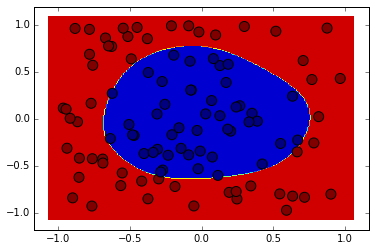

In [32]:
# Initialize decision surface for display
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                     np.arange(y_min, y_max, .01))
Z = np.c_[xx.ravel(), yy.ravel()]

# use keras model to make predictions across decision surface
Z = model.predict(Z, batch_size=100,verbose=1)

# Plot decision surface
Z = np.argmax(Z, 1)
Z = Z.reshape(xx.shape)
plt.jet()
plt.contourf(xx, yy, Z)
plt.scatter(x[:,0], x[:,1], c=y, s=100)
plt.show()

####Q #3: 

What is the effect of changing the batch size to 1 for training?  Do this by modifying the ``batch_size`` parameter in ``model.fit(...)`` above.  

**A**: See [Answer #3 below](#Answer-#3)

## Post-Lab Summary

If you would like to download this lab for later viewing, it is recommended you go to your browsers File menu (not the Jupyter notebook file menu) and save the complete web page.  This will ensure the images are copied down as well.

### More information

For more information on using Theano, visit [http://deeplearning.net/software/theano/](http://deeplearning.net/software/theano/). A description of the framework, how to use it, and plenty of examples similar to this lesson are posted. 

To learn more about these other topics, please visit:
* GPU accelerated machine learning: [http://www.nvidia.com/object/machine-learning.html](http://www.nvidia.com/object/machine-learning.html)
* Theano: [http://deeplearning.net/software/theano/](http://deeplearning.net/software/theano/)
* Torch: [http://torch.ch/](http://torch.ch/)
* DIGITS: [https://developer.nvidia.com/digits](https://developer.nvidia.com/digits)
* cuDNN: [https://developer.nvidia.com/cudnn](https://developer.nvidia.com/cudnn)

### Deep Learning Lab Series

Make sure to check out the rest of the classes in this Deep Learning lab series.  You can find them [here](https://developer.nvidia.com/deep-learning-courses).

### Acknowledgements

The logistic regression example used was inspired by Andrej Karpathy's [ConvnetJS](http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html) demonstration.  The "Key Theano concepts" section was largely adapted from Colin Raffel's [Theano tutorial](http://nbviewer.ipython.org/github/craffel/theano-tutorial/blob/master/Theano%20Tutorial.ipynb).  The "Convolutional layers" section was adapted from the Theano Deep Learning tutorial [here](http://deeplearning.net/tutorial/lenet.html#lenet).

## Lab Answers

### Answer #1
Reducing the learning rate causes the decision boundary to change much more slowly.

[Return to question](#Q-#1:)

### Answer #2
You will see that larger filters caused a more blurred feature map and smaller filters caused a sharper feature map.

[Return to question](#Q-#2:)

### Answer #3
Training becomes much slower.  This is because we are no longer able to benefit from the speed-up gained by parallelizing the processing of multiple input data samples at the same time on the GPU.

[Return to question](#Q-#3:)